In [178]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

#from scipy import ndimage as nd
#from scipy.fft import fft, ifft
#from scipy import fftpack

(2713, 4096)

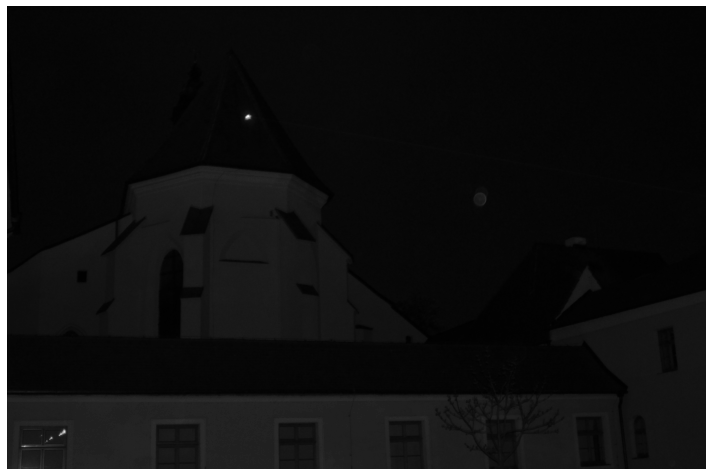

In [179]:
# img = cv2.imread("../dataset/honor/1.jpg")
# img = cv2.imread("../dataset/images/DSC_2749.JPG")
# img = cv2.imread("../dataset/images/DSC_2757.JPG")
# img = cv2.imread("../../apaler-acceleration/data/clouds.jpg")
img = cv2.imread("../../apaler-acceleration/data/buildings.jpg")

# img = cv2.resize(img, [1600, 1060])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(gray, cmap='gray')
ax.set_axis_off()
fig.tight_layout()
fig.savefig('../../files/houghlines/gray.png')

gray.shape

In [180]:
def mask_from_high_intensities(image, percent: int):
    hp = np.percentile(image, 100 - percent)
    ret, thres = cv2.threshold(image, thresh=hp, maxval=255, type=cv2.THRESH_BINARY)
    kernel_size = 7
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    binary = cv2.morphologyEx(thres, cv2.MORPH_OPEN, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(binary, cmap='gray')
    ax.set_axis_off()
    fig.tight_layout()
    fig.savefig('../../files/houghlines/mask.png')
    return binary

def remove_top_high_intensities(image, mask):
    replacement_value = np.percentile(image, 50)
    removed_blobs = image.copy()
    removed_blobs[mask == 255] = replacement_value
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(removed_blobs, cmap='gray')
    ax.set_axis_off()
    fig.tight_layout()
    fig.savefig('../../files/houghlines/removedblobs.png')
    return removed_blobs

In [181]:
def get_top_high_intensities(image, percent: int):
    threshold = np.percentile(image, 100 - percent)
    ret, thres = cv2.threshold(image, threshold, maxval=255,
                               type=cv2.THRESH_BINARY)

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(thres, cmap='gray')
    ax.set_axis_off()
    fig.tight_layout()
    fig.savefig('../../files/houghlines/topintensities.png')

    return thres

In [182]:
def get_intensities_in_range(image, percentile_low: int, percentile_high):
    assert percentile_low < percentile_high
    threshold_low = np.percentile(image, percentile_low)
    threshold_high = np.percentile(image, percentile_high)
    thres = ((image > threshold_low) & (image < threshold_high)).astype(np.uint8)

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(thres, cmap='gray')
    ax.set_axis_off()
    fig.tight_layout()
    fig.savefig('../../files/houghlines/topintensities.png')
    print(threshold_low, threshold_high)
    return thres

## Iteratively remove blobs
* Remove values with high intensity while retaining lines
* Get the top high intensities from the image
* Repeat until it stabilizes
* Run HoughLines

/tmp/ipykernel_41633/3368958599.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10, 8))


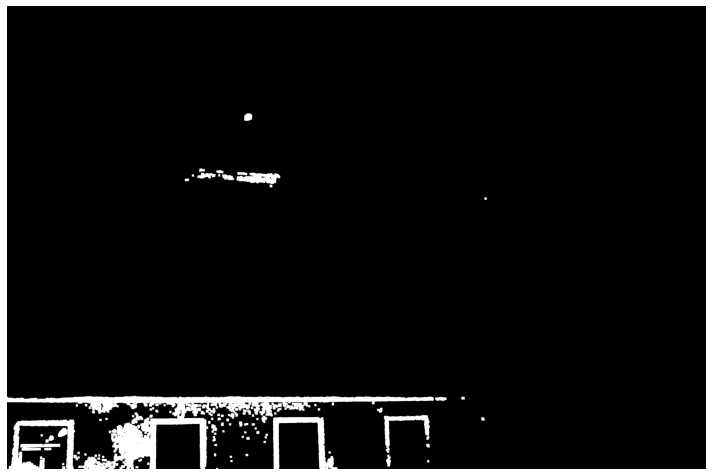

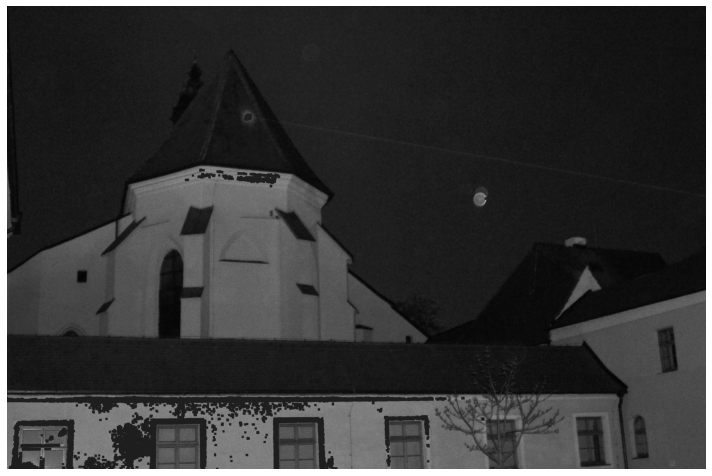

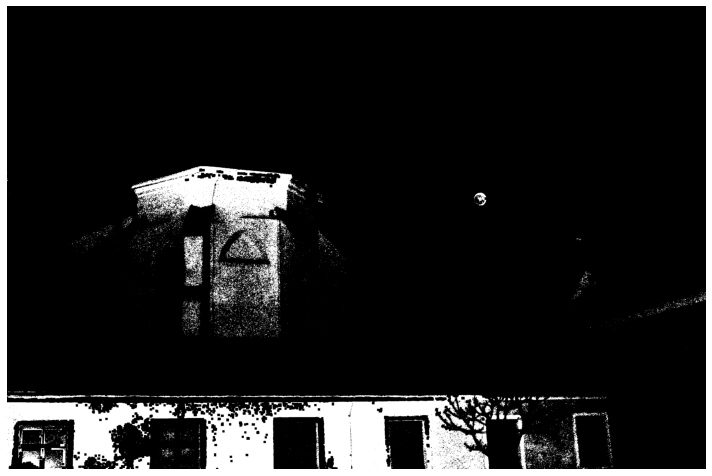

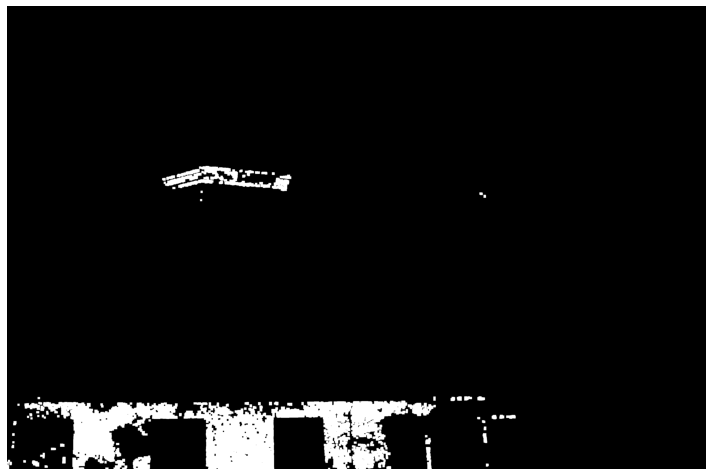

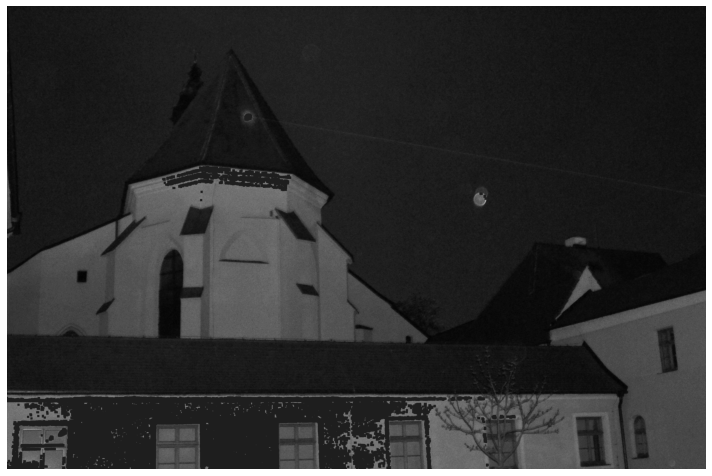

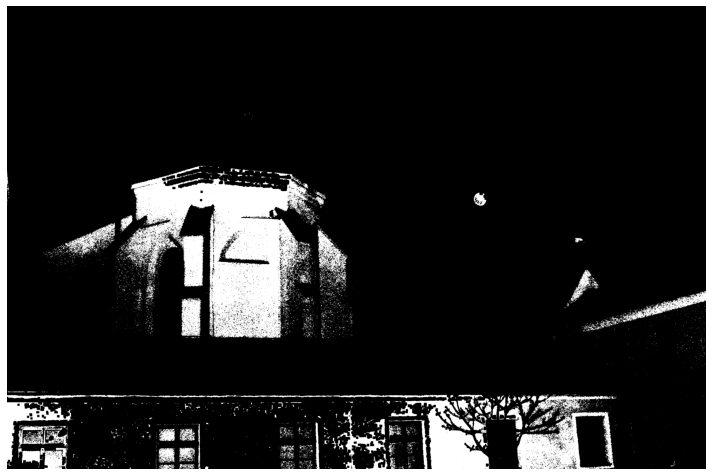

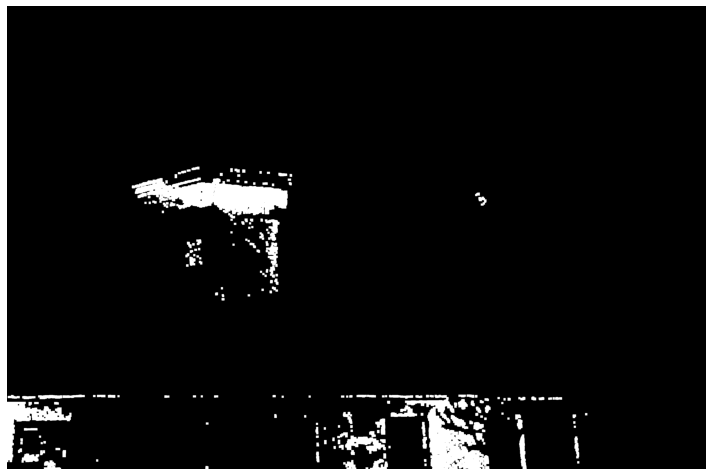

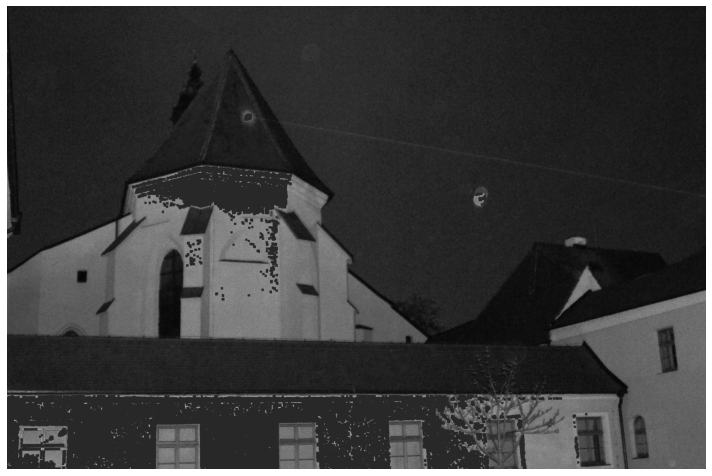

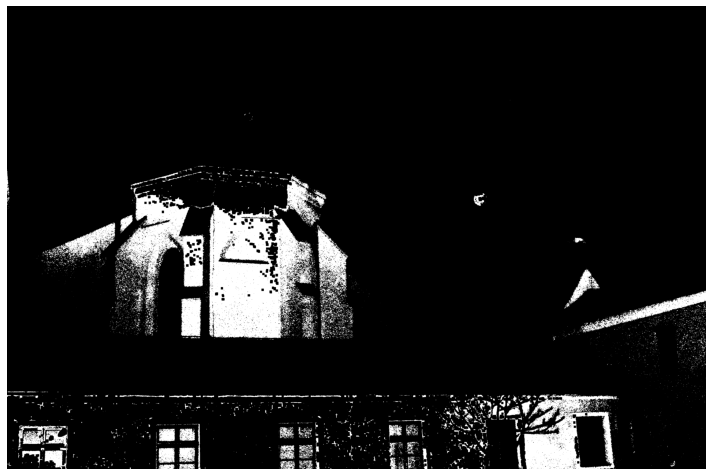

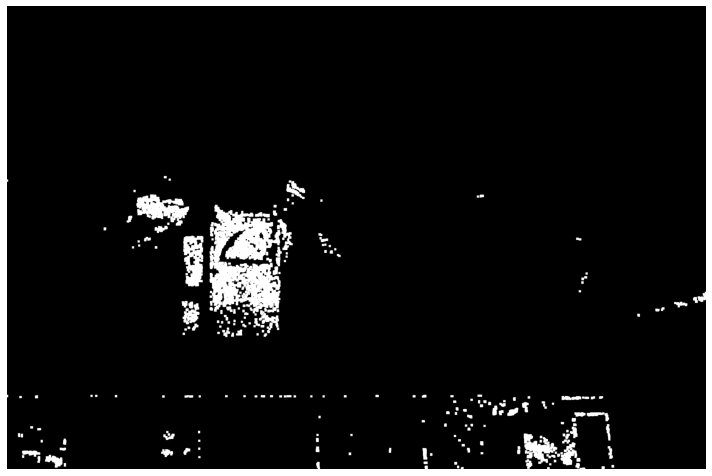

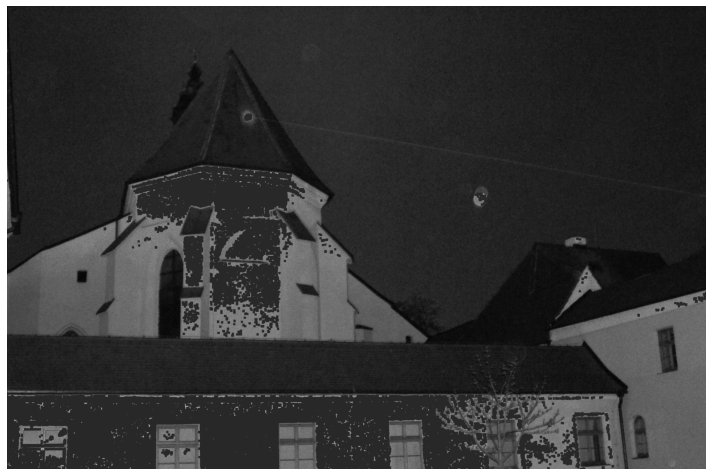

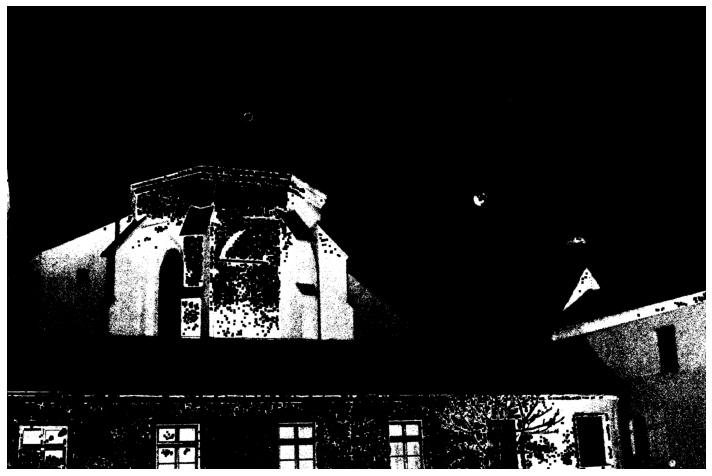

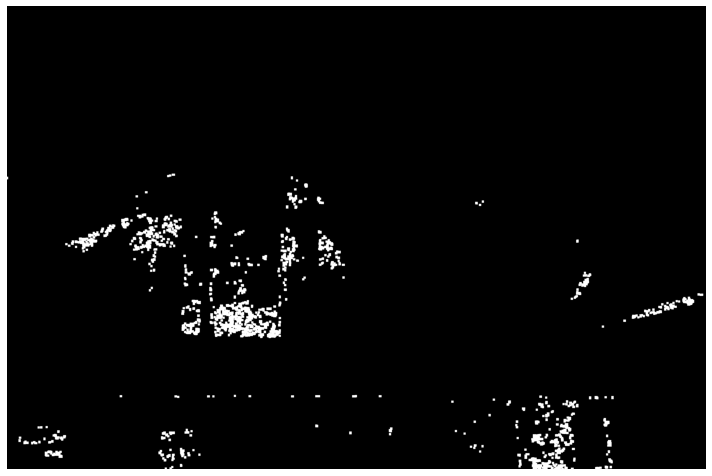

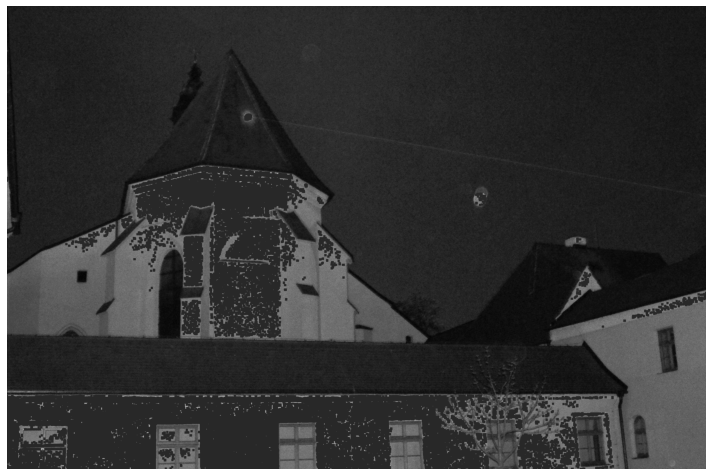

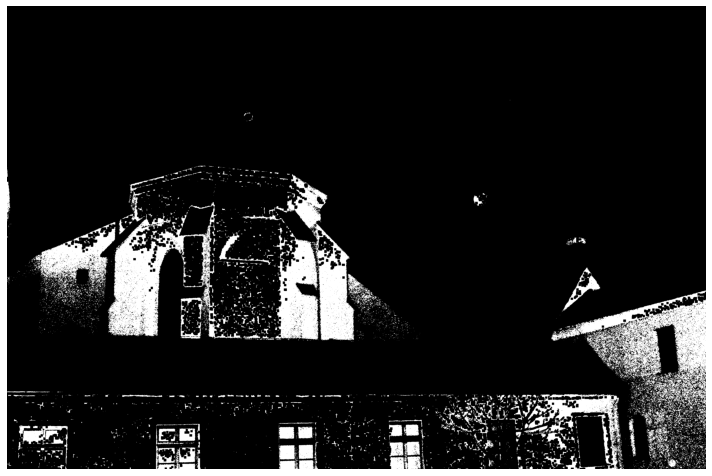

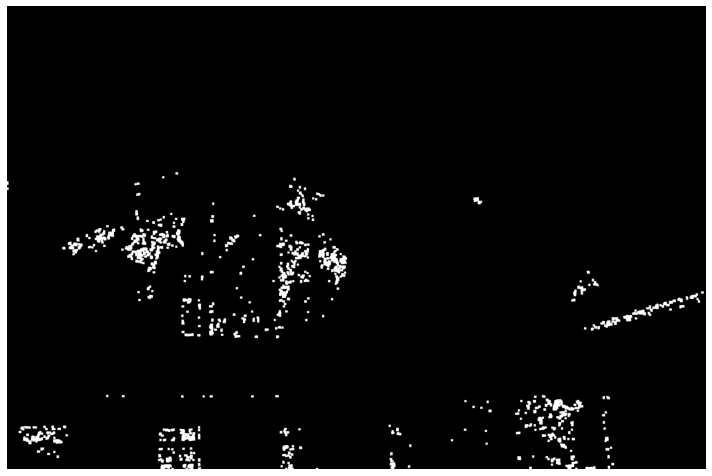

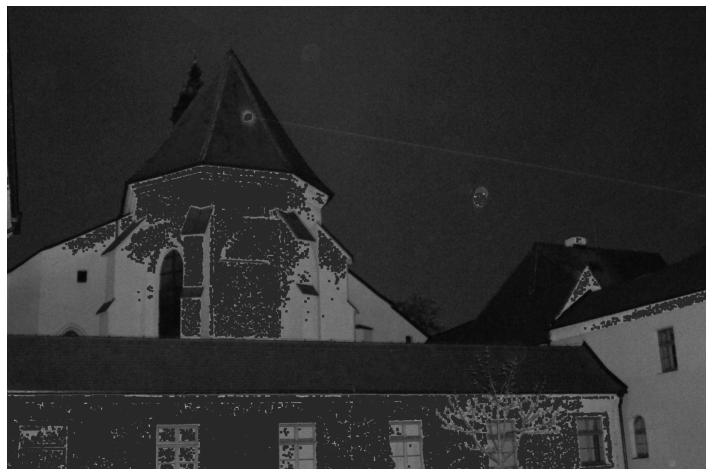

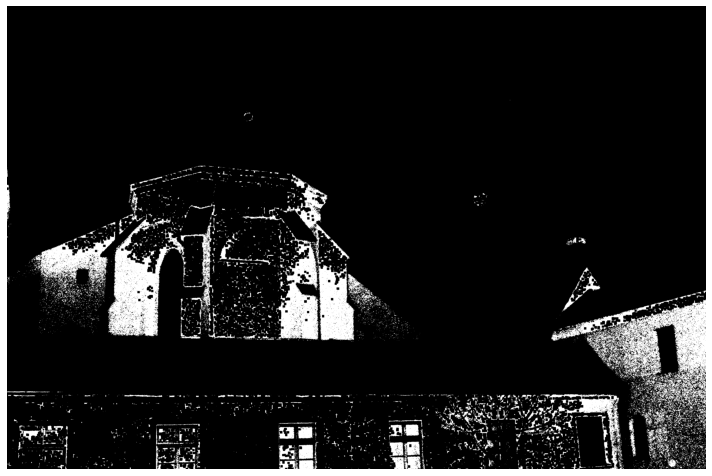

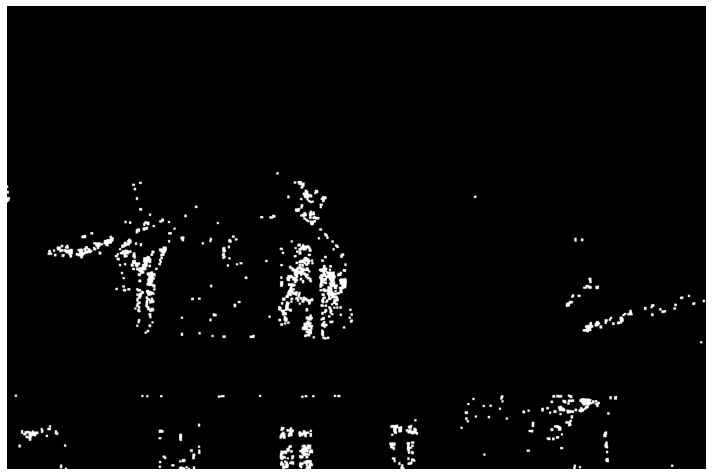

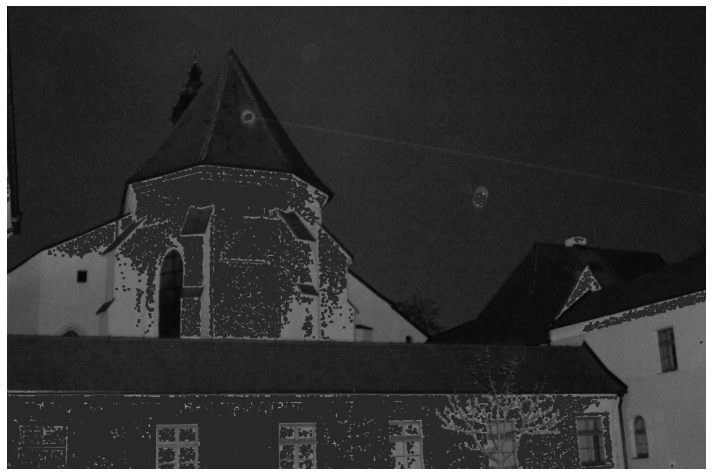

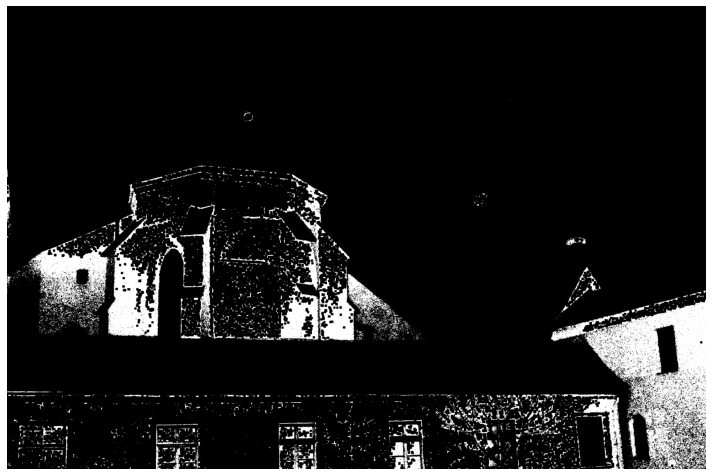

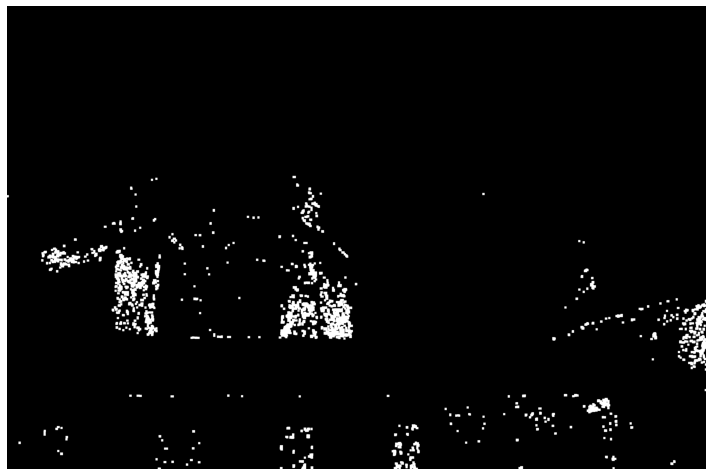

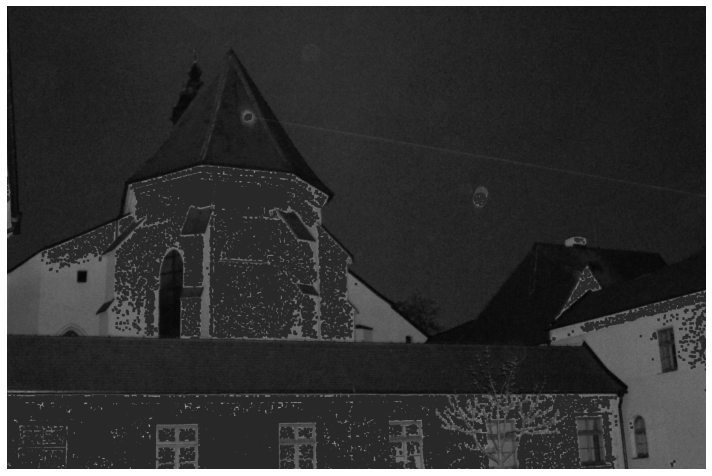

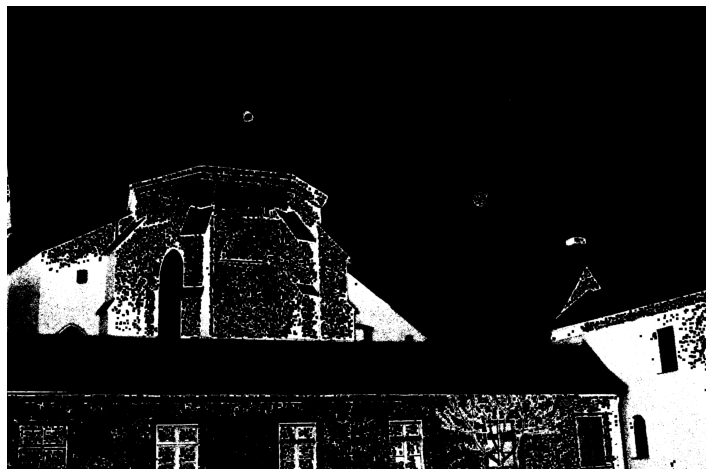

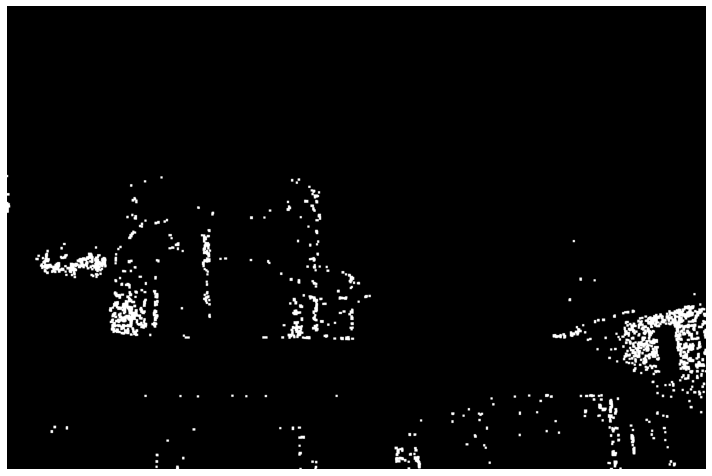

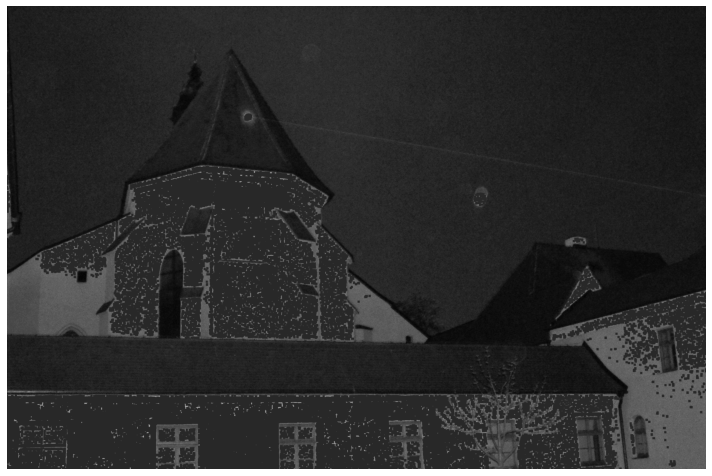

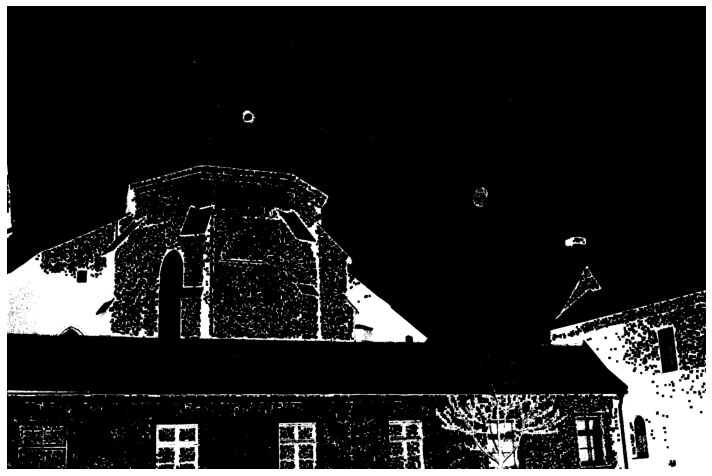

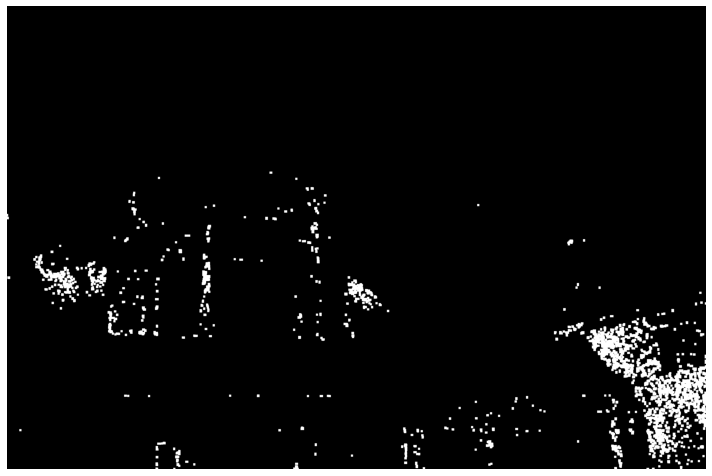

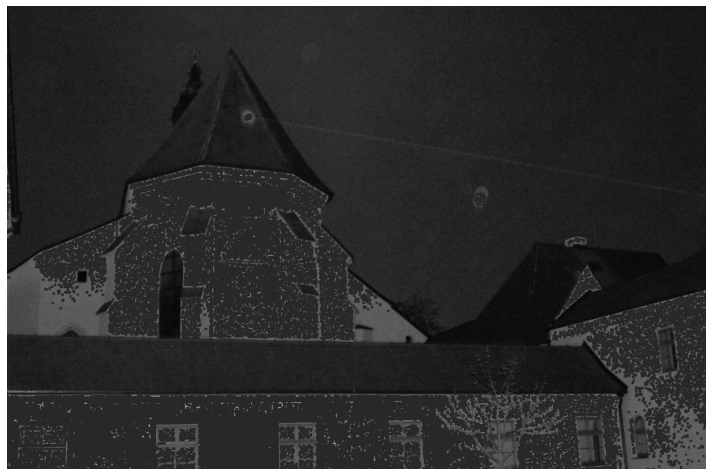

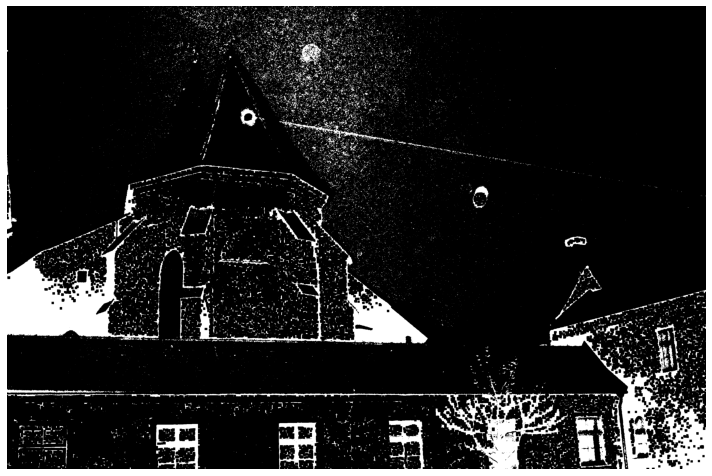

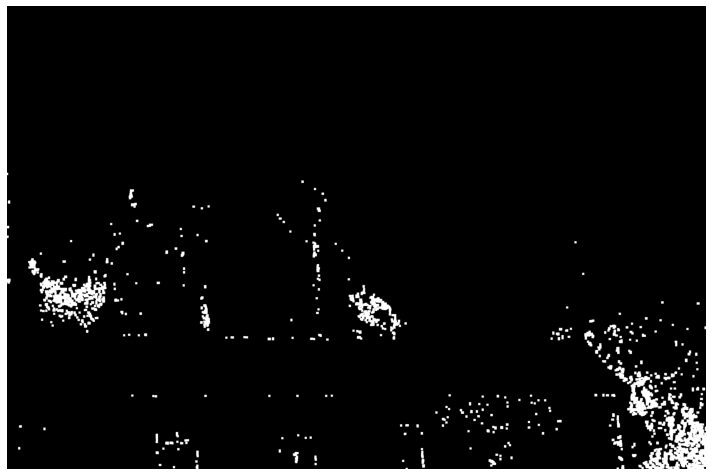

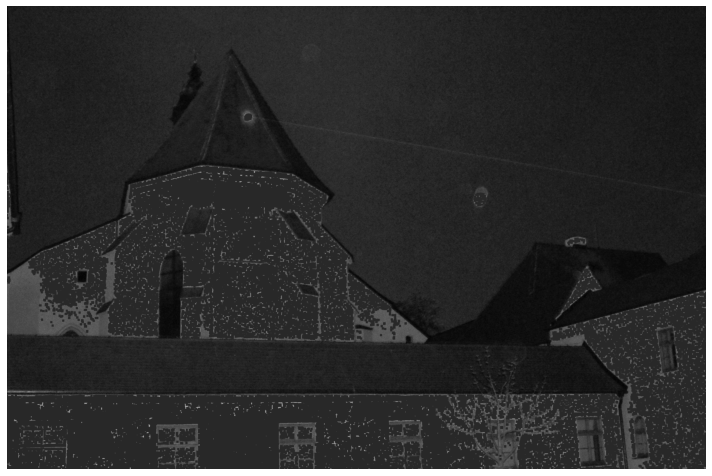

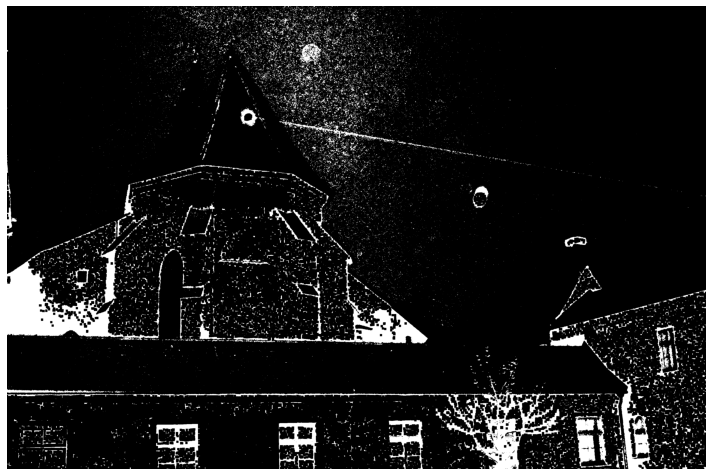

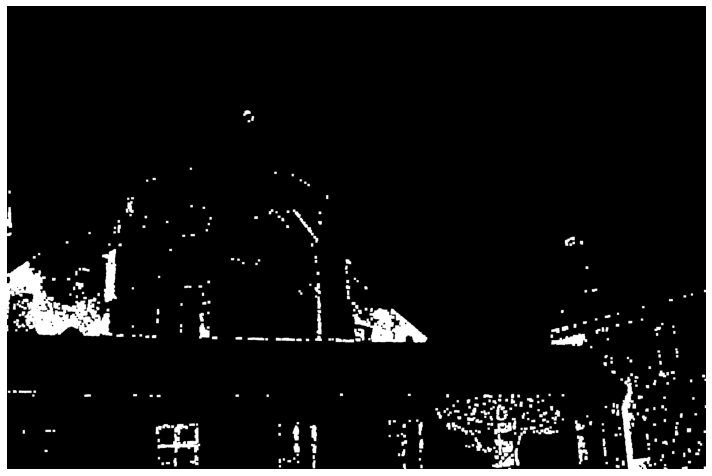

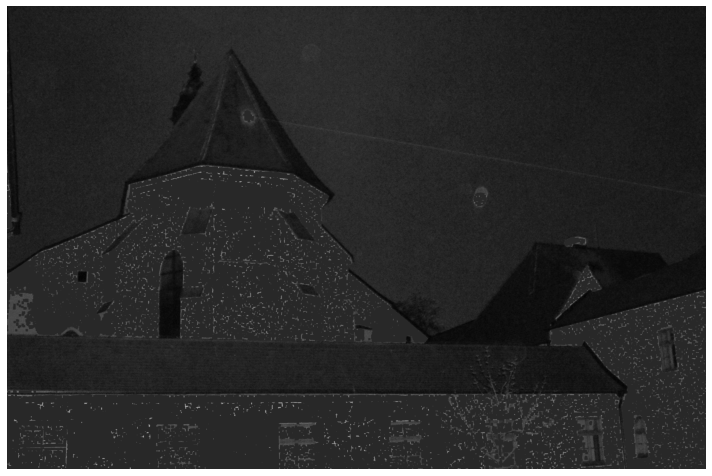

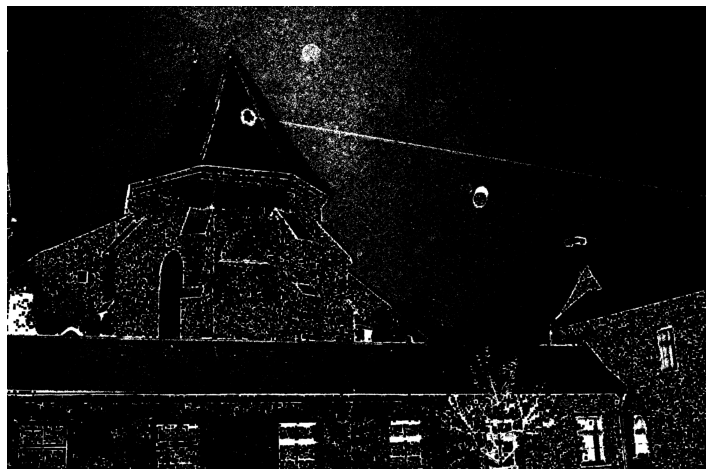

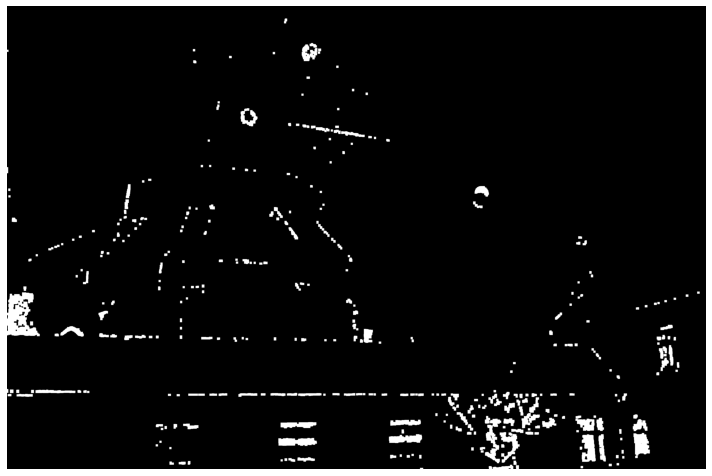

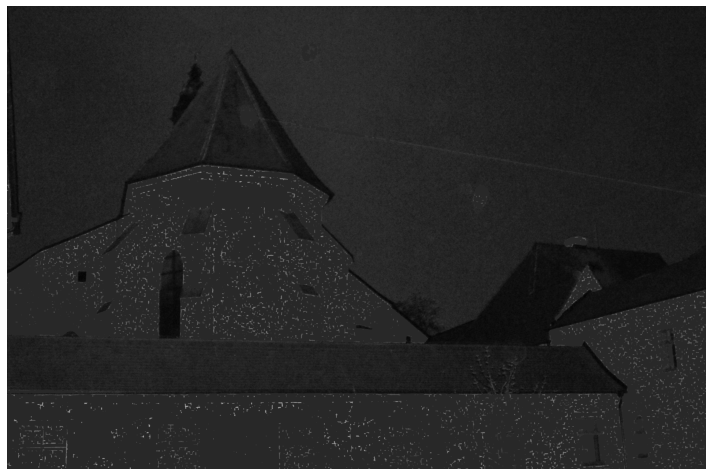

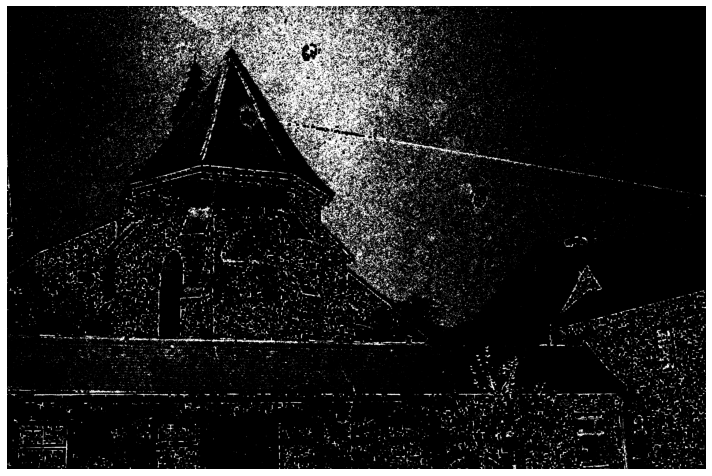

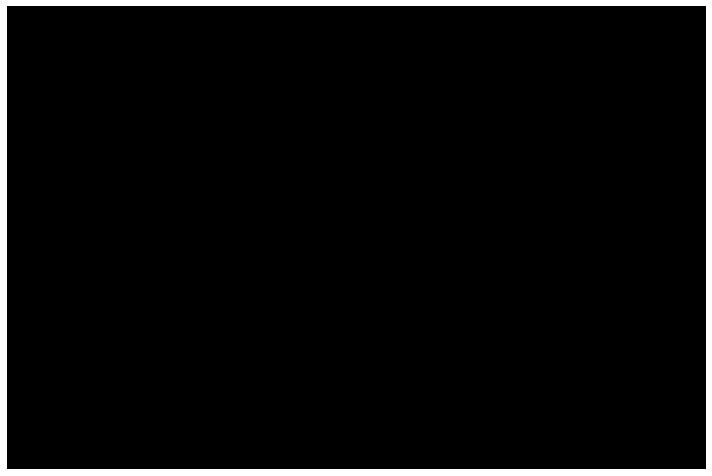

In [183]:
tmp_image = gray.copy()

top_intensities = None
while True:
    mask = mask_from_high_intensities(tmp_image, 5)
    if np.sum(mask) == 0:
        break
    tmp_image = remove_top_high_intensities(tmp_image, mask)
    top_intensities = get_top_high_intensities(tmp_image, 10)
    #top_intensities = get_intensities_in_range(tmp_image, 99, 100)

# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(48,48))
# tmp_image = clahe.apply(tmp_image)
# tmp_image = remove_top_high_intensities(tmp_image, mask)
# top_intensities = get_top_high_intensities(tmp_image, 2)


Lines: 61546


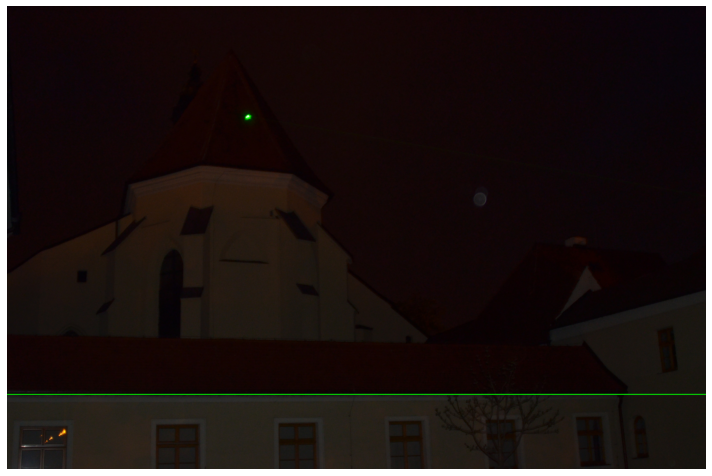

In [189]:
from geometry import line_end_points_on_image
import math

drawing = img.copy()
lines = cv2.HoughLines(top_intensities, 1, np.pi / 180, 50)

if lines is not None:
    for line in lines[:1]:
        for rho, theta in line:
            x0 = np.cos(theta) * rho
            y0 = np.sin(theta) * rho

            if np.isclose(y0, 0.0):
                # Handle the case with a vertical line:
                x1, y1 = int(x0), 0
                x2, y2 = int(x0), img.shape[0] - 1
                end_points = [(x1, y1), (x2, y2)]
            else:
                # The following function doesn't work for vertical lines
                end_points = line_end_points_on_image(rho, theta, img.shape[:2])
            pt1, pt2 = end_points

            cv2.line(drawing, pt1, pt2, (0,255,0), 3, cv2.LINE_AA)

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(drawing)
ax.set_axis_off()
fig.tight_layout()
fig.savefig('../../files/houghlines/result.png')
print("Lines:", len(lines))